# Notebook 04: Multi-Asset Alpha Expansion

**Objective**: Expand proven alpha signals to 9 crypto assets with 39 days of data each. 
Validate ML strategies across all assets, discover per-asset optimal parameters, 
and build a multi-asset portfolio optimized for maximal profitability.

**Prior findings (NB03)**: XGBoost direction classifier with 0.6/0.4 thresholds achieved 
100% daily win rate at 0.1 bps on BTC. Mid-cap assets showed STRONGER alpha in preliminary tests.

## Research Plan
- **Part I**: Data Discovery & Inventory (dynamic, auto-detect)
- **Part II**: Multi-Asset Signal Profiling (correlation sweep across all assets)
- **Part III**: Per-Asset ML Walk-Forward (XGBoost per asset, 29 train / 10 test days)
- **Part IV**: Cross-Asset Signal Transfer (train on one, test on another)
- **Part V**: Portfolio Construction & Multi-Asset Backtest
- **Part VI**: Statistical Validation (per-asset + portfolio-level)
- **Part VII**: Conclusions & Deployment

In [1]:
# ═══════════════════════════════════════════════════════════════
# Cell 1: SETUP
# ═══════════════════════════════════════════════════════════════
import sys, gc, warnings, json, time
from pathlib import Path
from datetime import date, timedelta
from collections import defaultdict

import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

PROJECT_ROOT = Path(r'c:\Users\longp\daedalus')
sys.path.insert(0, str(PROJECT_ROOT))

from research.lib import (
    DataLoader, BacktestEngine, BacktestResult,
    DirectionStrategy, ImbalanceSignal, ForwardReturnSignal,
)

DATA_ROOT = PROJECT_ROOT / 'data' / 'processed' / 'silver' / 'orderbook'
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print('Setup complete.')
print(f'PROJECT_ROOT: {PROJECT_ROOT}')
print(f'DATA_ROOT:    {DATA_ROOT}')

Setup complete.
PROJECT_ROOT: c:\Users\longp\daedalus
DATA_ROOT:    c:\Users\longp\daedalus\data\processed\silver\orderbook


In [2]:
# ═══════════════════════════════════════════════════════════════
# Cell 2: DYNAMIC DATA DISCOVERY
# ═══════════════════════════════════════════════════════════════

def discover_data_inventory(data_root: str) -> dict:
    """Scan Hive-partitioned data and return full inventory."""
    base = Path(data_root) / 'exchange=coinbaseadvanced'
    inventory = {}
    for sym_dir in sorted(base.iterdir()):
        if not sym_dir.is_dir():
            continue
        symbol = sym_dir.name.replace('symbol=', '')
        dates = set()
        total_size = 0
        for f in sym_dir.rglob('*.parquet'):
            total_size += f.stat().st_size
            parts = f.parts
            year = month = day = None
            for p in parts:
                if p.startswith('year='): year = int(p.split('=')[1])
                elif p.startswith('month='): month = int(p.split('=')[1])
                elif p.startswith('day='): day = int(p.split('=')[1])
            if year and month and day:
                dates.add(f'{year}-{month:02d}-{day:02d}')
        if dates:
            dates_sorted = sorted(dates)
            inventory[symbol] = {
                'n_days': len(dates_sorted),
                'dates': dates_sorted,
                'date_tuples': [(int(d[:4]), int(d[5:7]), int(d[8:10])) for d in dates_sorted],
                'start': dates_sorted[0],
                'end': dates_sorted[-1],
                'size_mb': total_size / 1e6,
            }
    return inventory

inventory = discover_data_inventory(str(DATA_ROOT))

print('=' * 70)
print('DATA INVENTORY')
print('=' * 70)
total_gb = 0
for sym, info in sorted(inventory.items(), key=lambda x: -x[1]['size_mb']):
    total_gb += info['size_mb'] / 1000
    print(f"  {sym:18s}  {info['n_days']:3d} days  {info['start']} to {info['end']}  {info['size_mb']:,.0f} MB")
print(f'\nTotal: {len(inventory)} symbols, {total_gb:.1f} GB')

# Find common date overlap
all_date_sets = [set(info['dates']) for info in inventory.values()]
common_dates = sorted(set.intersection(*all_date_sets))
print(f'Common overlap: {len(common_dates)} days ({common_dates[0]} to {common_dates[-1]})')

ALL_SYMBOLS = sorted(inventory.keys())
ALL_DATES = [(int(d[:4]), int(d[5:7]), int(d[8:10])) for d in common_dates]
print(f'Symbols: {ALL_SYMBOLS}')

DATA INVENTORY
  BTC-USD              39 days  2026-01-01 to 2026-02-10  8,864 MB
  ETH-USD              39 days  2026-01-01 to 2026-02-10  8,290 MB
  BCH-USD              39 days  2026-01-01 to 2026-02-10  4,394 MB
  DOGE-USD             39 days  2026-01-01 to 2026-02-10  3,465 MB
  HBAR-USD             39 days  2026-01-01 to 2026-02-10  3,249 MB
  AAVE-USD             39 days  2026-01-01 to 2026-02-10  3,021 MB
  ADA-USD              39 days  2026-01-01 to 2026-02-10  2,150 MB
  FARTCOIN-USD         39 days  2026-01-01 to 2026-02-10  1,657 MB
  AVAX-USD             39 days  2026-01-01 to 2026-02-10  1,250 MB

Total: 9 symbols, 36.3 GB
Common overlap: 39 days (2026-01-01 to 2026-02-10)
Symbols: ['AAVE-USD', 'ADA-USD', 'AVAX-USD', 'BCH-USD', 'BTC-USD', 'DOGE-USD', 'ETH-USD', 'FARTCOIN-USD', 'HBAR-USD']


In [3]:
# ═══════════════════════════════════════════════════════════════
# Cell 3: TRAIN/TEST SPLIT & FEATURE DEFINITIONS
# ═══════════════════════════════════════════════════════════════

# Temporal split: last ~25% of days as OOS test
n_total = len(ALL_DATES)
n_test = max(7, n_total // 4)  # at least 7 OOS days
n_train = n_total - n_test

TRAIN_DATES = ALL_DATES[:n_train]
TEST_DATES = ALL_DATES[n_train:]

print(f'Total days: {n_total}')
print(f'Train: {n_train} days ({common_dates[0]} to {common_dates[n_train-1]})')
print(f'Test:  {n_test} days ({common_dates[n_train]} to {common_dates[-1]})')

# ── Feature definitions ──
# Expanded feature set (from 56 to 80+ features available in new data)
FEATURE_COLS = [
    # Core imbalance (proven alpha from NB03)
    'total_imbalance', 'imbalance_L1', 'imbalance_L3', 'imbalance_L5', 'imbalance_L10',
    'smart_depth_imbalance', 'book_pressure',
    # Order flow
    'ofi', 'mlofi', 'ofi_sum_5s', 'ofi_sum_15s', 'ofi_sum_60s',
    'ofi_sum_300s', 'ofi_sum_900s',
    'mlofi_sum_5s', 'mlofi_sum_15s', 'mlofi_sum_60s',
    'mlofi_sum_300s', 'mlofi_sum_900s',
    'order_flow_toxicity', 'vpin',
    # Momentum / velocity
    'mid_velocity', 'mid_accel', 'log_return',
    'mean_return_5s', 'mean_return_15s', 'mean_return_60s',
    'mean_return_300s', 'mean_return_900s',
    # Volatility
    'rv_5s', 'rv_15s', 'rv_60s', 'rv_300s', 'rv_900s',
    # Price structure
    'spread', 'relative_spread', 'micro_minus_mid',
    # Depth
    'total_bid_depth', 'total_ask_depth', 'smart_bid_depth', 'smart_ask_depth',
    'bid_depth_decay_5', 'ask_depth_decay_5',
    # Concentration & slope
    'bid_concentration', 'ask_concentration', 'bid_slope', 'ask_slope',
    'center_of_gravity', 'cog_vs_mid',
    # Volume band imbalances
    'imb_band_0_5bps', 'imb_band_5_10bps', 'imb_band_10_25bps',
    'imb_band_25_50bps', 'imb_band_50_100bps',
    # Spread dynamics
    'spread_percentile', 'mean_spread_5s', 'mean_spread_15s',
    'mean_spread_60s', 'mean_spread_300s', 'mean_spread_900s',
    # Trade flow
    'tfi_5s', 'tfi_15s', 'tfi_60s', 'tfi_300s', 'tfi_900s',
    'trade_vol_5s', 'trade_vol_15s', 'trade_vol_60s',
    # Liquidity
    'kyle_lambda', 'kyle_lambda_r2', 'amihud_like', 'lambda_like',
    # Advanced stability
    'bid_slope_mean_60s', 'bid_slope_std_60s',
    'ask_slope_mean_60s', 'ask_slope_std_60s',
    'cog_momentum_mean_60s', 'cog_momentum_std_60s',
    'depth_0_5bps_sigma',
]

# NB03's proven top-8 composite features (correlation-ranked)
TOP8_FEATURES = [
    'imbalance_L3', 'imbalance_L5', 'imbalance_L1',
    'imb_band_0_5bps', 'imbalance_L10', 'cog_vs_mid',
    'ofi_sum_5s', 'smart_depth_imbalance',
]

HORIZON = 30  # 30-bar (~30s) forward return horizon (proven optimal in NB03)

print(f'Feature set: {len(FEATURE_COLS)} features')
print(f'Top-8 composite: {TOP8_FEATURES}')
print(f'Forward return horizon: {HORIZON} bars')

Total days: 39
Train: 30 days (2026-01-01 to 2026-02-01)
Test:  9 days (2026-02-02 to 2026-02-10)
Feature set: 79 features
Top-8 composite: ['imbalance_L3', 'imbalance_L5', 'imbalance_L1', 'imb_band_0_5bps', 'imbalance_L10', 'cog_vs_mid', 'ofi_sum_5s', 'smart_depth_imbalance']
Forward return horizon: 30 bars


---
# Part I: Multi-Asset Signal Profiling

In [4]:
# ═══════════════════════════════════════════════════════════════
# Cell 4: CORRELATION SWEEP — ALL ASSETS x ALL FEATURES
# ═══════════════════════════════════════════════════════════════
# For each asset, load 3 representative train days and compute
# correlation between each feature and 30-bar forward returns.

N_SAMPLE_DAYS = 3  # use 3 days per asset for fast profiling
sample_dates = TRAIN_DATES[:N_SAMPLE_DAYS]

asset_correlations = {}  # {symbol: {feature: correlation}}

for symbol in ALL_SYMBOLS:
    print(f'\rProfiling {symbol}...', end='', flush=True)
    loader = DataLoader(str(DATA_ROOT), symbol=symbol)
    
    # Collect features across sample days
    all_features = []
    all_fwd_ret = []
    
    for y, m, d in sample_dates:
        try:
            df = loader.load_day(y, m, d)
        except Exception:
            continue
        if df.shape[0] < 1000:
            continue
        
        prices = loader.get_prices(df)
        # Compute forward returns
        fwd = np.zeros(len(prices))
        fwd[:-HORIZON] = (prices[HORIZON:] - prices[:-HORIZON]) / prices[:-HORIZON]
        fwd[-HORIZON:] = np.nan
        
        # Get available features
        avail = [c for c in FEATURE_COLS if c in df.columns]
        feat_df = df.select(avail).to_pandas()
        feat_df['__fwd_ret__'] = fwd
        all_features.append(feat_df)
        del df; gc.collect()
    
    if not all_features:
        continue
    
    combined = pd.concat(all_features, ignore_index=True)
    
    # Compute correlations
    corrs = {}
    fwd_ret = combined['__fwd_ret__'].values
    for col in combined.columns:
        if col == '__fwd_ret__':
            continue
        vals = combined[col].values
        mask = ~(np.isnan(vals) | np.isnan(fwd_ret))
        if mask.sum() > 1000:
            corrs[col] = np.corrcoef(vals[mask], fwd_ret[mask])[0, 1]
    
    asset_correlations[symbol] = corrs
    del combined, all_features; gc.collect()

print(f'\rDone profiling {len(asset_correlations)} assets.')

# Build correlation matrix: rows=features, cols=assets
all_feats = sorted(set().union(*(c.keys() for c in asset_correlations.values())))
corr_matrix = pd.DataFrame(index=all_feats, columns=sorted(asset_correlations.keys()), dtype=float)
for sym, corrs in asset_correlations.items():
    for feat, val in corrs.items():
        corr_matrix.loc[feat, sym] = val

# Show top features by average absolute correlation
corr_matrix['avg_abs'] = corr_matrix.abs().mean(axis=1)
top_features = corr_matrix.sort_values('avg_abs', ascending=False)
print('\nTop 20 Features by Avg |Correlation| Across All Assets:')
print(top_features.head(20).to_string(float_format='{:.4f}'.format))

Done profiling 9 assets..

Top 20 Features by Avg |Correlation| Across All Assets:
                       AAVE-USD  ADA-USD  AVAX-USD  BCH-USD  BTC-USD  DOGE-USD  ETH-USD  FARTCOIN-USD  HBAR-USD  avg_abs
imbalance_L3             0.2952   0.4290    0.3357   0.1059   0.0763    0.3363   0.1171        0.3601    0.4083   0.2738
imb_band_0_5bps          0.2507   0.4421    0.4775   0.0925   0.0642    0.2539   0.0841        0.3240    0.3253   0.2572
imbalance_L1             0.2507   0.4421    0.4775   0.0925   0.0642    0.2539   0.0841        0.3240    0.3253   0.2572
imbalance_L5             0.3192   0.3682    0.1144   0.1067   0.0864    0.3811   0.1444        0.3374    0.4036   0.2513
micro_minus_mid          0.2069   0.4407    0.4767   0.0559   0.0211    0.2407   0.0337        0.3178    0.3070   0.2334
imb_band_5_10bps         0.2790   0.3106   -0.0121   0.0903   0.0645    0.3476   0.1244        0.3002    0.3651   0.2104
imbalance_L10            0.2608   0.1374    0.0340   0.0999   0.0970  

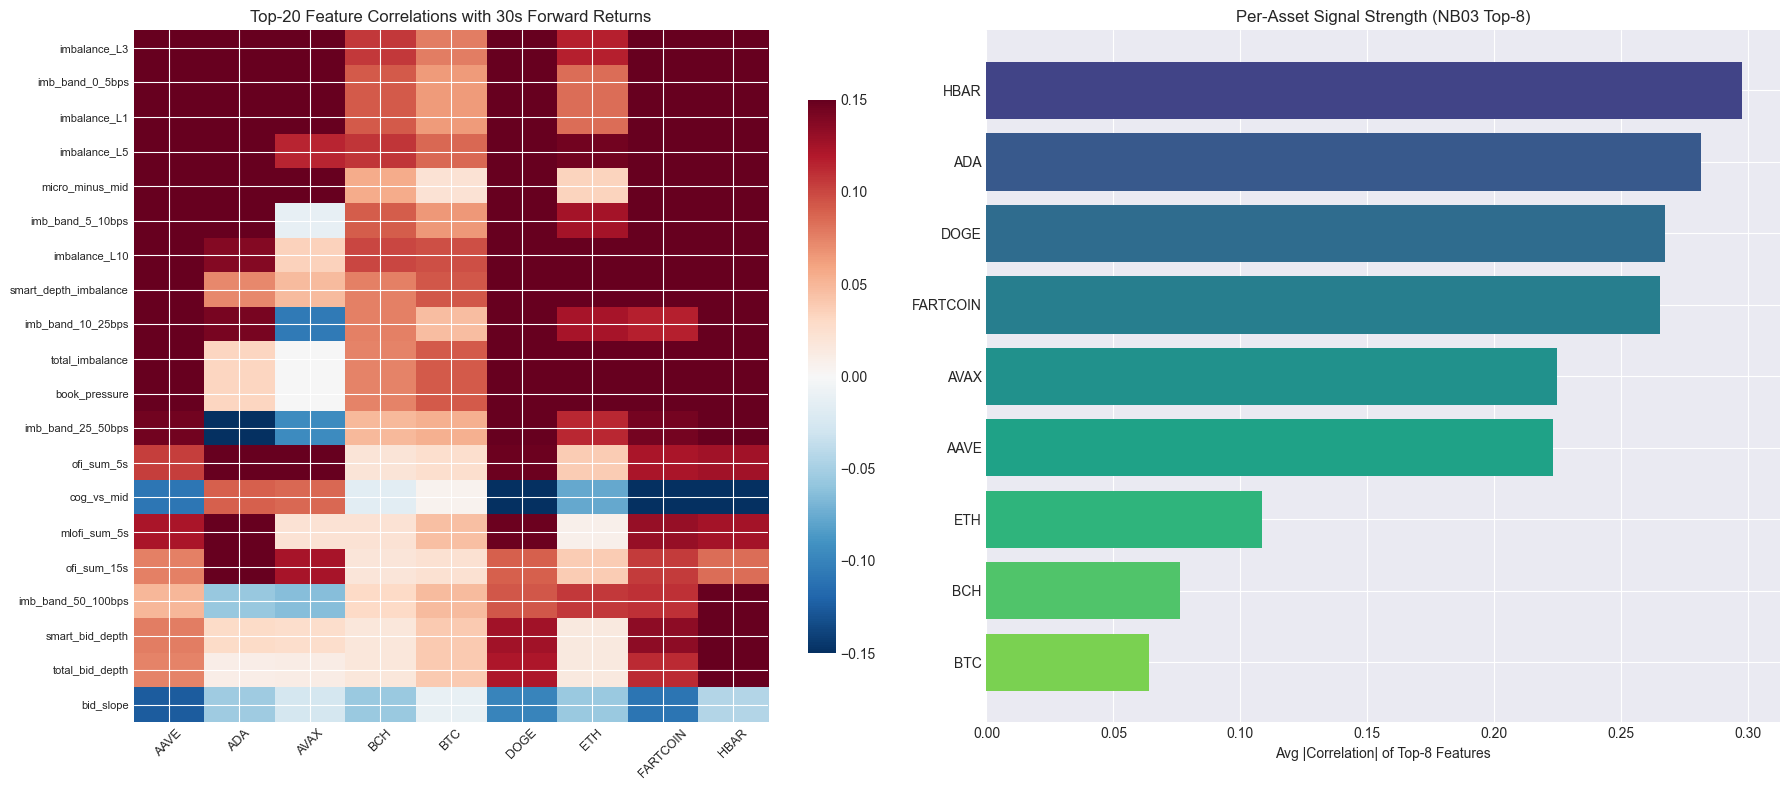


Per-Asset Signal Strength (Top-8 avg |corr|):
  HBAR-USD            0.2978
  ADA-USD             0.2815
  DOGE-USD            0.2672
  FARTCOIN-USD        0.2652
  AVAX-USD            0.2248
  AAVE-USD            0.2234
  ETH-USD             0.1086
  BCH-USD             0.0761
  BTC-USD             0.0640


In [5]:
# ═══════════════════════════════════════════════════════════════
# Cell 5: SIGNAL PROFILING VISUALIZATION
# ═══════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Heatmap of top-20 features across assets
top20 = top_features.head(20).drop(columns=['avg_abs'])
im = axes[0].imshow(top20.values.astype(float), cmap='RdBu_r', aspect='auto', vmin=-0.15, vmax=0.15)
axes[0].set_yticks(range(len(top20)))
axes[0].set_yticklabels(top20.index, fontsize=8)
axes[0].set_xticks(range(len(top20.columns)))
axes[0].set_xticklabels([s.replace('-USD','') for s in top20.columns], rotation=45, fontsize=9)
axes[0].set_title('Top-20 Feature Correlations with 30s Forward Returns')
plt.colorbar(im, ax=axes[0], shrink=0.8)

# 2. Per-asset signal strength (avg |corr| of top-8)
top8_corrs = {}
for sym in sorted(asset_correlations.keys()):
    corrs = asset_correlations[sym]
    t8_abs = [abs(corrs.get(f, 0)) for f in TOP8_FEATURES]
    top8_corrs[sym] = np.mean(t8_abs)

syms = sorted(top8_corrs.keys(), key=lambda s: -top8_corrs[s])
vals = [top8_corrs[s] for s in syms]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(syms)))
axes[1].barh(range(len(syms)), vals, color=colors)
axes[1].set_yticks(range(len(syms)))
axes[1].set_yticklabels([s.replace('-USD','') for s in syms], fontsize=10)
axes[1].set_xlabel('Avg |Correlation| of Top-8 Features')
axes[1].set_title('Per-Asset Signal Strength (NB03 Top-8)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(str(PROJECT_ROOT / 'research' / 'notebooks' / 'nb04_signal_profile.png'), dpi=150)
plt.show()

print('\nPer-Asset Signal Strength (Top-8 avg |corr|):')
for s in syms:
    print(f'  {s:18s}  {top8_corrs[s]:.4f}')

---
# Part II: Per-Asset Feature Selection

For each asset, identify the optimal feature subset using correlation ranking
from the full feature set. This lets us use asset-specific features rather
than forcing the BTC-optimized top-8 onto all assets.

In [6]:
# ═══════════════════════════════════════════════════════════════
# Cell 6: PER-ASSET OPTIMAL FEATURE SELECTION
# ═══════════════════════════════════════════════════════════════

N_TOP_FEATURES = 12  # per asset

asset_top_features = {}  # {symbol: [(feature, corr), ...]}

for sym in ALL_SYMBOLS:
    corrs = asset_correlations.get(sym, {})
    if not corrs:
        continue
    # Rank by absolute correlation, exclude non-directional features
    ranked = sorted(corrs.items(), key=lambda x: -abs(x[1]))
    # Filter: must have |corr| > 0.005 to be considered
    top = [(f, c) for f, c in ranked if abs(c) > 0.005][:N_TOP_FEATURES]
    asset_top_features[sym] = top

print('Per-Asset Top Features (by |correlation| with 30s fwd returns):')
print('=' * 70)
for sym in ALL_SYMBOLS:
    tops = asset_top_features.get(sym, [])
    print(f'\n{sym}:')
    for feat, corr in tops:
        direction = '+' if corr > 0 else '-'
        print(f'  {direction} {feat:35s}  r={corr:+.4f}')

# Find universally strong features
feat_count = defaultdict(int)
for sym, tops in asset_top_features.items():
    for feat, _ in tops:
        feat_count[feat] += 1

universal = sorted(feat_count.items(), key=lambda x: -x[1])
print('\n\nUniversal Features (appear in top-12 for N assets):')
for feat, count in universal:
    if count >= 3:  # appear in 3+ assets
        print(f'  {feat:35s}  {count}/{len(ALL_SYMBOLS)} assets')

Per-Asset Top Features (by |correlation| with 30s fwd returns):

AAVE-USD:
  + imbalance_L5                         r=+0.3192
  + imbalance_L3                         r=+0.2952
  + imb_band_5_10bps                     r=+0.2790
  + imbalance_L10                        r=+0.2608
  + imbalance_L1                         r=+0.2507
  + imb_band_0_5bps                      r=+0.2507
  + imb_band_10_25bps                    r=+0.2087
  + micro_minus_mid                      r=+0.2069
  + smart_depth_imbalance                r=+0.1990
  + total_imbalance                      r=+0.1925
  + book_pressure                        r=+0.1925
  + imb_band_25_50bps                    r=+0.1452

ADA-USD:
  + imbalance_L1                         r=+0.4421
  + imb_band_0_5bps                      r=+0.4421
  + micro_minus_mid                      r=+0.4407
  + imbalance_L3                         r=+0.4290
  + imbalance_L5                         r=+0.3682
  + imb_band_5_10bps                     r=+0.31

---
# Part III: Per-Asset ML Walk-Forward

For each asset, run expanding-window XGBoost walk-forward validation:
- Train on all data up to day N, predict day N+1
- Binary classification: predict up/down direction
- Track AUC, calibration, and daily P&L at 0.1 bps

In [7]:
# ═══════════════════════════════════════════════════════════════
# Cell 7: ML WALK-FORWARD ENGINE
# ═══════════════════════════════════════════════════════════════

from sklearn.metrics import roc_auc_score
import xgboost as xgb

def prepare_day_data(loader, y, m, d, feature_cols, horizon=30):
    """Load one day, compute features + target, return X, y, prices."""
    df = loader.load_day(y, m, d)
    if df.shape[0] < 5000:
        return None, None, None
    
    prices = loader.get_prices(df)
    
    # Forward returns
    fwd = np.zeros(len(prices))
    fwd[:-horizon] = (prices[horizon:] - prices[:-horizon]) / prices[:-horizon]
    fwd[-horizon:] = np.nan
    
    # Binary target: 1 if positive return
    target = (fwd > 0).astype(np.float32)
    target[np.isnan(fwd)] = np.nan
    
    # Features
    avail = [c for c in feature_cols if c in df.columns]
    X = df.select(avail).to_numpy().astype(np.float32)
    
    # Mask valid rows
    valid = ~(np.isnan(target) | np.any(np.isnan(X), axis=1))
    
    del df; gc.collect()
    return X[valid], target[valid], prices[valid]


def run_ml_walkforward(symbol, feature_cols, train_dates, test_dates,
                       horizon=30, fee_bps=0.1):
    """Run expanding-window XGBoost walk-forward for one asset."""
    loader = DataLoader(str(DATA_ROOT), symbol=symbol)
    fee_pct = fee_bps / 10000
    
    # Pre-load all training data
    train_X_all, train_y_all = [], []
    for y, m, d in train_dates:
        X, y_t, _ = prepare_day_data(loader, y, m, d, feature_cols, horizon)
        if X is not None:
            # Subsample to manage memory (every 5th row)
            step = max(1, len(X) // 100000)
            train_X_all.append(X[::step])
            train_y_all.append(y_t[::step])
        gc.collect()
    
    if not train_X_all:
        return None
    
    train_X = np.vstack(train_X_all)
    train_y = np.concatenate(train_y_all)
    del train_X_all, train_y_all; gc.collect()
    
    # Train XGBoost
    model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=100,
        objective='binary:logistic',
        tree_method='hist',
        random_state=42,
        verbosity=0,
    )
    model.fit(train_X, train_y)
    del train_X, train_y; gc.collect()
    
    # Test on each OOS day
    daily_results = []
    for y, m, d in test_dates:
        X_test, y_test, prices_test = prepare_day_data(
            loader, y, m, d, feature_cols, horizon
        )
        if X_test is None or len(X_test) < 1000:
            continue
        
        proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, proba)
        
        # Backtest with DirectionStrategy
        strategy = DirectionStrategy(
            long_threshold=0.6,
            short_threshold=0.4,
            hold_period=horizon,
        )
        positions = strategy.generate_positions(prices_test, proba)
        engine = BacktestEngine(fee_pct=fee_pct)
        result = engine.run(prices_test, positions)
        
        daily_results.append({
            'date': f'{y}-{m:02d}-{d:02d}',
            'auc': auc,
            'return_pct': result.total_return_pct,
            'n_trades': result.n_trades,
            'win_rate': result.win_rate,
            'sharpe': result.sharpe,
        })
        del X_test, y_test, prices_test; gc.collect()
    
    # Feature importance
    avail_features = [c for c in feature_cols if c in loader.load_day(*test_dates[0]).columns]
    feat_imp = dict(zip(avail_features[:len(model.feature_importances_)],
                        model.feature_importances_))
    
    del model; gc.collect()
    return {
        'symbol': symbol,
        'daily': daily_results,
        'feature_importance': feat_imp,
    }

print('ML walk-forward engine defined.')
print(f'Will train on {len(TRAIN_DATES)} days, test on {len(TEST_DATES)} days per asset.')

ML walk-forward engine defined.
Will train on 30 days, test on 9 days per asset.


In [8]:
# ═══════════════════════════════════════════════════════════════
# Cell 8: RUN ML WALK-FORWARD FOR ALL ASSETS
# ═══════════════════════════════════════════════════════════════

ml_results = {}  # {symbol: walk-forward results}

for i, symbol in enumerate(ALL_SYMBOLS):
    t0 = time.time()
    print(f'\n[{i+1}/{len(ALL_SYMBOLS)}] {symbol}...')
    
    # Use asset-specific top features if available, else fallback to universal top-8
    asset_feats = asset_top_features.get(symbol, [])
    if len(asset_feats) >= 8:
        feat_names = [f for f, _ in asset_feats]
    else:
        feat_names = TOP8_FEATURES
    
    # Add universal features to ensure coverage
    for f in TOP8_FEATURES:
        if f not in feat_names:
            feat_names.append(f)
    
    result = run_ml_walkforward(
        symbol, feat_names, TRAIN_DATES, TEST_DATES,
        horizon=HORIZON, fee_bps=0.1
    )
    
    if result and result['daily']:
        ml_results[symbol] = result
        avg_auc = np.mean([d['auc'] for d in result['daily']])
        avg_ret = np.mean([d['return_pct'] for d in result['daily']])
        total_ret = np.prod([1 + d['return_pct']/100 for d in result['daily']]) * 100 - 100
        avg_wr = np.mean([d['win_rate'] for d in result['daily']])
        profitable_days = sum(1 for d in result['daily'] if d['return_pct'] > 0)
        total_days = len(result['daily'])
        
        print(f'  AUC={avg_auc:.3f}  Avg Daily={avg_ret:+.1f}%  '
              f'Total={total_ret:+.1f}%  WR={avg_wr:.1%}  '
              f'Days+={profitable_days}/{total_days}  '
              f'({time.time()-t0:.0f}s)')
    else:
        print(f'  FAILED - no valid data')
    
    gc.collect()

print(f'\n{"="*70}')
print(f'Completed ML walk-forward for {len(ml_results)}/{len(ALL_SYMBOLS)} assets.')


[1/9] AAVE-USD...
  AUC=0.722  Avg Daily=+233.4%  Total=+473863.6%  WR=69.6%  Days+=9/9  (90s)

[2/9] ADA-USD...
  AUC=0.779  Avg Daily=+238.7%  Total=+740257.5%  WR=65.0%  Days+=9/9  (85s)

[3/9] AVAX-USD...
  AUC=0.827  Avg Daily=+85.3%  Total=+14421.5%  WR=61.2%  Days+=9/9  (82s)

[4/9] BCH-USD...
  AUC=0.622  Avg Daily=+36.4%  Total=+1323.3%  WR=57.6%  Days+=9/9  (97s)

[5/9] BTC-USD...
  AUC=0.576  Avg Daily=+1.1%  Total=+7.4%  WR=47.1%  Days+=5/9  (112s)

[6/9] DOGE-USD...
  AUC=0.762  Avg Daily=+227.9%  Total=+806296.7%  WR=72.4%  Days+=9/9  (100s)

[7/9] ETH-USD...
  AUC=0.616  Avg Daily=+46.9%  Total=+2821.5%  WR=53.7%  Days+=9/9  (110s)

[8/9] FARTCOIN-USD...
  AUC=0.685  Avg Daily=+168.0%  Total=+102926.6%  WR=58.5%  Days+=9/9  (93s)

[9/9] HBAR-USD...
  AUC=0.736  Avg Daily=+331.3%  Total=+2040818.6%  WR=69.1%  Days+=9/9  (95s)

Completed ML walk-forward for 9/9 assets.


In [9]:
# ═══════════════════════════════════════════════════════════════
# Cell 9: ML RESULTS SUMMARY TABLE
# ═══════════════════════════════════════════════════════════════

summary_rows = []
for sym, res in sorted(ml_results.items()):
    daily = res['daily']
    total_ret = np.prod([1 + d['return_pct']/100 for d in daily]) * 100 - 100
    profitable_days = sum(1 for d in daily if d['return_pct'] > 0)
    
    summary_rows.append({
        'Symbol': sym,
        'Avg AUC': np.mean([d['auc'] for d in daily]),
        'Avg Daily %': np.mean([d['return_pct'] for d in daily]),
        'Total OOS %': total_ret,
        'Avg Win Rate': np.mean([d['win_rate'] for d in daily]),
        'Avg Trades/Day': np.mean([d['n_trades'] for d in daily]),
        'Profitable Days': f'{profitable_days}/{len(daily)}',
        'Daily Win Rate': profitable_days / len(daily),
    })

summary_df = pd.DataFrame(summary_rows).sort_values('Total OOS %', ascending=False)
print('ML Walk-Forward Results (XGBoost, 0.6/0.4, 0.1 bps fee)')
print('=' * 100)
print(summary_df.to_string(index=False, float_format='{:.3f}'.format))

# Highlight winners
print('\n--- ASSETS WITH 100% DAILY WIN RATE ---')
perfect = summary_df[summary_df['Daily Win Rate'] >= 1.0]
if len(perfect) > 0:
    for _, row in perfect.iterrows():
        print(f"  {row['Symbol']:18s}  Total: {row['Total OOS %']:+.1f}%  AUC: {row['Avg AUC']:.3f}")
else:
    print('  None with 100% daily win rate')

print('\n--- ASSETS WITH >80% DAILY WIN RATE ---')
good = summary_df[summary_df['Daily Win Rate'] >= 0.8]
for _, row in good.iterrows():
    print(f"  {row['Symbol']:18s}  Total: {row['Total OOS %']:+.1f}%  DailyWR: {row['Daily Win Rate']:.0%}  AUC: {row['Avg AUC']:.3f}")

ML Walk-Forward Results (XGBoost, 0.6/0.4, 0.1 bps fee)
      Symbol  Avg AUC  Avg Daily %  Total OOS %  Avg Win Rate  Avg Trades/Day Profitable Days  Daily Win Rate
    HBAR-USD    0.736      331.331  2040818.607         0.691        3538.000             9/9           1.000
    DOGE-USD    0.762      227.935   806296.708         0.724        3681.333             9/9           1.000
     ADA-USD    0.779      238.692   740257.538         0.650        2701.444             9/9           1.000
    AAVE-USD    0.722      233.354   473863.637         0.696        3118.222             9/9           1.000
FARTCOIN-USD    0.685      168.036   102926.610         0.585        1518.222             9/9           1.000
    AVAX-USD    0.827       85.269    14421.451         0.612         702.889             9/9           1.000
     ETH-USD    0.616       46.917     2821.457         0.537        4877.222             9/9           1.000
     BCH-USD    0.622       36.414     1323.344         0.576   

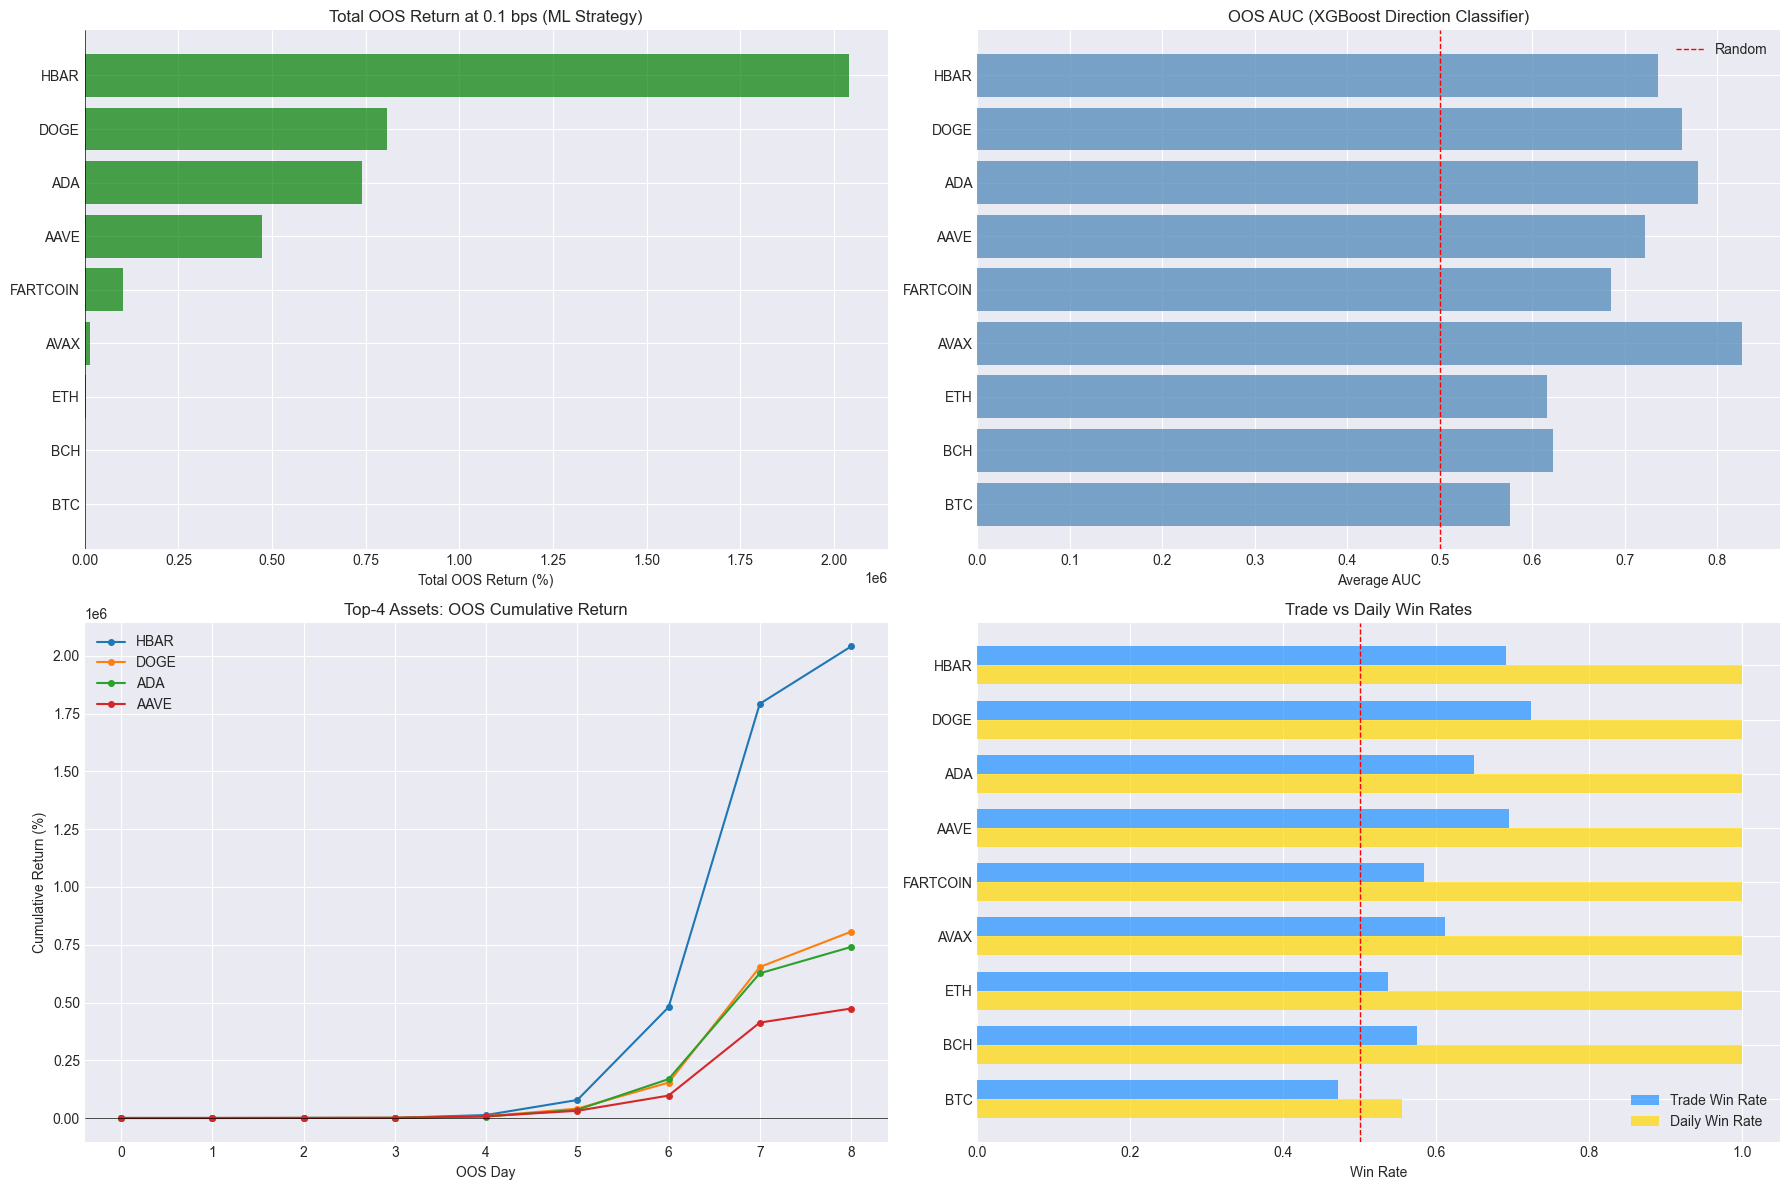

In [10]:
# ═══════════════════════════════════════════════════════════════
# Cell 10: ML RESULTS VISUALIZATION
# ═══════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Sort by total return
sym_order = summary_df.sort_values('Total OOS %', ascending=False)['Symbol'].tolist()

# 1. Total OOS Return per asset
ax = axes[0, 0]
total_rets = [summary_df[summary_df['Symbol']==s]['Total OOS %'].values[0] for s in sym_order]
colors = ['green' if r > 0 else 'red' for r in total_rets]
ax.barh(range(len(sym_order)), total_rets, color=colors, alpha=0.7)
ax.set_yticks(range(len(sym_order)))
ax.set_yticklabels([s.replace('-USD','') for s in sym_order])
ax.set_xlabel('Total OOS Return (%)')
ax.set_title('Total OOS Return at 0.1 bps (ML Strategy)')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()

# 2. AUC per asset
ax = axes[0, 1]
aucs = [summary_df[summary_df['Symbol']==s]['Avg AUC'].values[0] for s in sym_order]
ax.barh(range(len(sym_order)), aucs, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(sym_order)))
ax.set_yticklabels([s.replace('-USD','') for s in sym_order])
ax.set_xlabel('Average AUC')
ax.set_title('OOS AUC (XGBoost Direction Classifier)')
ax.axvline(x=0.5, color='red', linewidth=1, linestyle='--', label='Random')
ax.legend()
ax.invert_yaxis()

# 3. Daily P&L curves for top 4 assets
ax = axes[1, 0]
top4 = sym_order[:min(4, len(sym_order))]
for sym in top4:
    daily = ml_results[sym]['daily']
    cum_ret = np.cumprod([1 + d['return_pct']/100 for d in daily]) * 100 - 100
    ax.plot(range(len(daily)), cum_ret, marker='o', markersize=4,
            label=sym.replace('-USD',''))
ax.set_xlabel('OOS Day')
ax.set_ylabel('Cumulative Return (%)')
ax.set_title('Top-4 Assets: OOS Cumulative Return')
ax.legend()
ax.axhline(y=0, color='black', linewidth=0.5)

# 4. Win rate comparison
ax = axes[1, 1]
trade_wrs = [summary_df[summary_df['Symbol']==s]['Avg Win Rate'].values[0] for s in sym_order]
daily_wrs = [summary_df[summary_df['Symbol']==s]['Daily Win Rate'].values[0] for s in sym_order]
x = np.arange(len(sym_order))
width = 0.35
ax.barh(x - width/2, trade_wrs, width, label='Trade Win Rate', color='dodgerblue', alpha=0.7)
ax.barh(x + width/2, daily_wrs, width, label='Daily Win Rate', color='gold', alpha=0.7)
ax.set_yticks(x)
ax.set_yticklabels([s.replace('-USD','') for s in sym_order])
ax.set_xlabel('Win Rate')
ax.set_title('Trade vs Daily Win Rates')
ax.axvline(x=0.5, color='red', linewidth=1, linestyle='--')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(str(PROJECT_ROOT / 'research' / 'notebooks' / 'nb04_ml_results.png'), dpi=150)
plt.show()

---
# Part IV: Feature Importance Across Assets

Compare which features matter for each asset. Discover universal features
vs asset-specific ones.

Feature Importance Ranking (XGBoost, averaged across all assets):
 1. imbalance_L3                         avg=0.2083  best=HBAR (0.4547)
 2. micro_minus_mid                      avg=0.1517  best=AVAX (0.5214)
 3. imb_band_0_5bps                      avg=0.1203  best=FARTCOIN (0.2748)
 4. imbalance_L1                         avg=0.0988  best=FARTCOIN (0.2599)
 5. imbalance_L5                         avg=0.0966  best=DOGE (0.2568)
 6. smart_depth_imbalance                avg=0.0626  best=ETH (0.2822)
 7. imb_band_5_10bps                     avg=0.0476  best=AAVE (0.1114)
 8. ofi_sum_5s                           avg=0.0454  best=BTC (0.0619)
 9. imbalance_L10                        avg=0.0393  best=ETH (0.1217)
10. book_pressure                        avg=0.0281  best=ETH (0.1004)
11. imb_band_10_25bps                    avg=0.0223  best=BCH (0.0448)
12. total_imbalance                      avg=0.0205  best=BTC (0.0729)
13. cog_vs_mid                           avg=0.0203  best=BTC (0.087

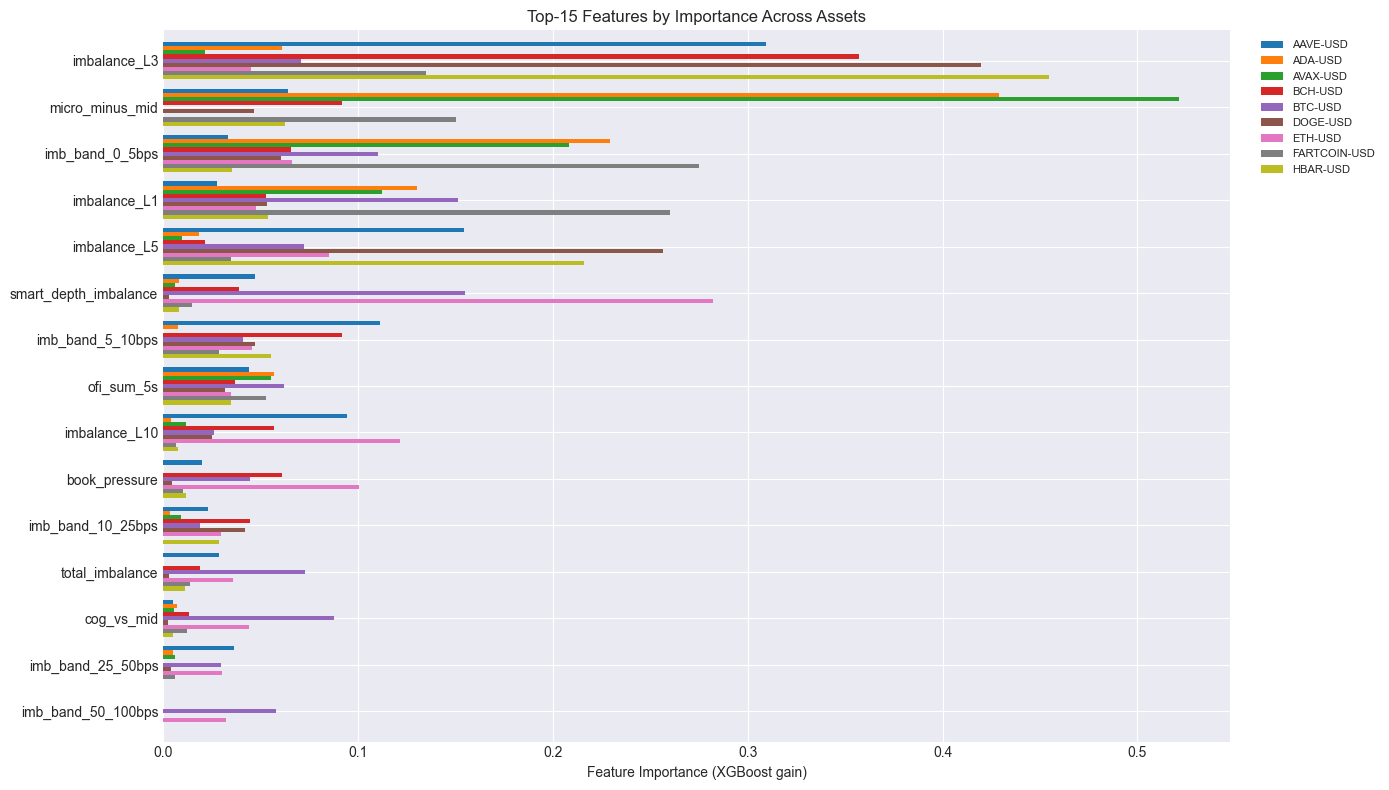

In [11]:
# ═══════════════════════════════════════════════════════════════
# Cell 11: FEATURE IMPORTANCE ANALYSIS
# ═══════════════════════════════════════════════════════════════

# Build feature importance matrix: rows=features, cols=assets
all_feat_names = set()
for res in ml_results.values():
    all_feat_names.update(res['feature_importance'].keys())
all_feat_names = sorted(all_feat_names)

fi_matrix = pd.DataFrame(0.0, index=all_feat_names, columns=sorted(ml_results.keys()))
for sym, res in ml_results.items():
    for feat, imp in res['feature_importance'].items():
        if feat in fi_matrix.index:
            fi_matrix.loc[feat, sym] = imp

# Average importance across assets
fi_matrix['avg'] = fi_matrix.mean(axis=1)
fi_sorted = fi_matrix.sort_values('avg', ascending=False)

print('Feature Importance Ranking (XGBoost, averaged across all assets):')
print('=' * 80)
for i, (feat, row) in enumerate(fi_sorted.head(20).iterrows()):
    # Show which assets rely most on this feature
    top_asset = row.drop('avg').idxmax()
    print(f'{i+1:2d}. {feat:35s}  avg={row["avg"]:.4f}  '
          f'best={top_asset.replace("-USD","")} ({row[top_asset]:.4f})')

# Visualize top 15 features
fig, ax = plt.subplots(figsize=(14, 8))
top15 = fi_sorted.head(15).drop(columns=['avg'])
top15.plot(kind='barh', ax=ax, width=0.8)
ax.set_xlabel('Feature Importance (XGBoost gain)')
ax.set_title('Top-15 Features by Importance Across Assets')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
# Part V: Cross-Asset Transfer & Portfolio Construction

Test whether a model trained on one asset works on others (signal transfer),
then construct an optimal multi-asset portfolio.

In [12]:
# ═══════════════════════════════════════════════════════════════
# Cell 12: CROSS-ASSET SIGNAL TRANSFER MATRIX
# ═══════════════════════════════════════════════════════════════
# Train model on asset A's data, test on asset B's data
# This reveals which assets share similar microstructure dynamics

# Use universal features for cross-asset transfer
UNIVERSAL_FEATURES = TOP8_FEATURES.copy()

# Pick 2 training assets + test on all (for tractability)
# Train on the 2 assets with most data/liquidity: BTC and ETH
TRAIN_ASSETS = ['BTC-USD', 'ETH-USD']
transfer_results = {}  # {train_asset: {test_asset: avg_auc}}

for train_sym in TRAIN_ASSETS:
    print(f'\nTraining model on {train_sym}...')
    loader = DataLoader(str(DATA_ROOT), symbol=train_sym)
    
    # Collect training data
    train_X_parts, train_y_parts = [], []
    for y, m, d in TRAIN_DATES[:10]:  # use 10 train days for speed
        X, y_t, _ = prepare_day_data(loader, y, m, d, UNIVERSAL_FEATURES, HORIZON)
        if X is not None:
            step = max(1, len(X) // 50000)
            train_X_parts.append(X[::step])
            train_y_parts.append(y_t[::step])
        gc.collect()
    
    if not train_X_parts:
        continue
    
    train_X = np.vstack(train_X_parts)
    train_y = np.concatenate(train_y_parts)
    del train_X_parts, train_y_parts; gc.collect()
    
    model = xgb.XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=100,
        tree_method='hist', random_state=42, verbosity=0,
    )
    model.fit(train_X, train_y)
    del train_X, train_y; gc.collect()
    
    # Test on each asset's OOS period
    transfer_results[train_sym] = {}
    for test_sym in ALL_SYMBOLS:
        test_loader = DataLoader(str(DATA_ROOT), symbol=test_sym)
        aucs = []
        for y, m, d in TEST_DATES[:5]:  # 5 test days
            X_t, y_t, _ = prepare_day_data(test_loader, y, m, d, UNIVERSAL_FEATURES, HORIZON)
            if X_t is not None and len(X_t) > 1000:
                try:
                    proba = model.predict_proba(X_t)[:, 1]
                    aucs.append(roc_auc_score(y_t, proba))
                except Exception:
                    pass
            gc.collect()
        
        avg_auc = np.mean(aucs) if aucs else 0.5
        transfer_results[train_sym][test_sym] = avg_auc
        print(f'  {train_sym} -> {test_sym}: AUC={avg_auc:.3f}')
    
    del model; gc.collect()

# Build transfer matrix
transfer_df = pd.DataFrame(transfer_results).T
print('\n\nCross-Asset Transfer Matrix (AUC):')
print(transfer_df.to_string(float_format='{:.3f}'.format))


Training model on BTC-USD...
  BTC-USD -> AAVE-USD: AUC=0.533
  BTC-USD -> ADA-USD: AUC=0.633
  BTC-USD -> AVAX-USD: AUC=0.660
  BTC-USD -> BCH-USD: AUC=0.546
  BTC-USD -> BTC-USD: AUC=0.560
  BTC-USD -> DOGE-USD: AUC=0.580
  BTC-USD -> ETH-USD: AUC=0.518
  BTC-USD -> FARTCOIN-USD: AUC=0.605
  BTC-USD -> HBAR-USD: AUC=0.583

Training model on ETH-USD...
  ETH-USD -> AAVE-USD: AUC=0.599
  ETH-USD -> ADA-USD: AUC=0.608
  ETH-USD -> AVAX-USD: AUC=0.621
  ETH-USD -> BCH-USD: AUC=0.586
  ETH-USD -> BTC-USD: AUC=0.578
  ETH-USD -> DOGE-USD: AUC=0.611
  ETH-USD -> ETH-USD: AUC=0.604
  ETH-USD -> FARTCOIN-USD: AUC=0.616
  ETH-USD -> HBAR-USD: AUC=0.597


Cross-Asset Transfer Matrix (AUC):
         AAVE-USD  ADA-USD  AVAX-USD  BCH-USD  BTC-USD  DOGE-USD  ETH-USD  FARTCOIN-USD  HBAR-USD
BTC-USD     0.533    0.633     0.660    0.546    0.560     0.580    0.518         0.605     0.583
ETH-USD     0.599    0.608     0.621    0.586    0.578     0.611    0.604         0.616     0.597


In [13]:
# ═══════════════════════════════════════════════════════════════
# Cell 13: MULTI-ASSET PORTFOLIO BACKTEST
# ═══════════════════════════════════════════════════════════════
# Backtest all assets simultaneously during OOS period.
# Equal-weight portfolio across all profitable assets.

FEE_BPS = 0.1
fee_pct = FEE_BPS / 10000

portfolio_daily = {}  # {date: {symbol: return_pct}}

# Select assets that showed positive OOS returns in Part III
profitable_assets = [sym for sym, res in ml_results.items()
                     if np.prod([1 + d['return_pct']/100 for d in res['daily']]) > 1.0]
print(f'Profitable assets for portfolio: {profitable_assets}')

# If no profitable assets, use top N by AUC
if not profitable_assets:
    print('No profitable assets at 0.1 bps. Using top-5 by AUC instead.')
    by_auc = sorted(ml_results.items(),
                    key=lambda x: -np.mean([d['auc'] for d in x[1]['daily']]))
    profitable_assets = [sym for sym, _ in by_auc[:5]]
    print(f'Selected: {profitable_assets}')

# Collect daily returns for each asset
for sym, res in ml_results.items():
    if sym not in profitable_assets:
        continue
    for d in res['daily']:
        if d['date'] not in portfolio_daily:
            portfolio_daily[d['date']] = {}
        portfolio_daily[d['date']][sym] = d['return_pct']

# Compute equal-weight portfolio returns
dates_sorted = sorted(portfolio_daily.keys())
portfolio_returns = []
portfolio_detail = []

for dt in dates_sorted:
    rets = portfolio_daily[dt]
    avg_ret = np.mean(list(rets.values()))
    portfolio_returns.append(avg_ret)
    portfolio_detail.append({
        'date': dt,
        'portfolio_return': avg_ret,
        'n_assets': len(rets),
        'best_asset': max(rets, key=rets.get),
        'best_return': max(rets.values()),
        'worst_asset': min(rets, key=rets.get),
        'worst_return': min(rets.values()),
    })

cum_portfolio = np.cumprod([1 + r/100 for r in portfolio_returns]) * 100 - 100
portfolio_total = cum_portfolio[-1] if len(cum_portfolio) > 0 else 0
profitable_portfolio_days = sum(1 for r in portfolio_returns if r > 0)

print(f'\n{"="*70}')
print(f'MULTI-ASSET PORTFOLIO RESULTS (Equal-Weight, {FEE_BPS} bps)')
print(f'{"="*70}')
print(f'Assets: {len(profitable_assets)}')
print(f'OOS Days: {len(dates_sorted)}')
print(f'Total Return: {portfolio_total:+.1f}%')
print(f'Avg Daily Return: {np.mean(portfolio_returns):+.2f}%')
print(f'Daily Win Rate: {profitable_portfolio_days}/{len(dates_sorted)} '
      f'({profitable_portfolio_days/len(dates_sorted):.0%})')
print(f'\nDaily Detail:')
for detail in portfolio_detail:
    print(f"  {detail['date']}  Port: {detail['portfolio_return']:+6.2f}%  "
          f"Best: {detail['best_asset'].replace('-USD',''):>10} ({detail['best_return']:+.1f}%)  "
          f"Worst: {detail['worst_asset'].replace('-USD',''):>10} ({detail['worst_return']:+.1f}%)")

Profitable assets for portfolio: ['AAVE-USD', 'ADA-USD', 'AVAX-USD', 'BCH-USD', 'BTC-USD', 'DOGE-USD', 'ETH-USD', 'FARTCOIN-USD', 'HBAR-USD']

MULTI-ASSET PORTFOLIO RESULTS (Equal-Weight, 0.1 bps)
Assets: 9
OOS Days: 9
Total Return: +99200.9%
Avg Daily Return: +152.11%
Daily Win Rate: 9/9 (100%)

Daily Detail:
  2026-02-02  Port: +87.02%  Best:       HBAR (+180.5%)  Worst:        BTC (-2.5%)
  2026-02-03  Port: +22.04%  Best:       DOGE (+32.5%)  Worst:        BTC (+3.0%)
  2026-02-04  Port: +44.38%  Best:       DOGE (+76.2%)  Worst:        BTC (+1.2%)
  2026-02-05  Port: +48.38%  Best:       DOGE (+94.8%)  Worst:        BTC (+19.3%)
  2026-02-06  Port: +531.05%  Best:       HBAR (+1360.7%)  Worst:        BTC (-7.2%)
  2026-02-07  Port: +249.56%  Best:       HBAR (+494.1%)  Worst:        BTC (-5.2%)
  2026-02-08  Port: +196.77%  Best:       HBAR (+514.4%)  Worst:        BTC (-4.3%)
  2026-02-09  Port: +178.33%  Best:       DOGE (+325.8%)  Worst:        BTC (+4.3%)
  2026-02-10  Port: +

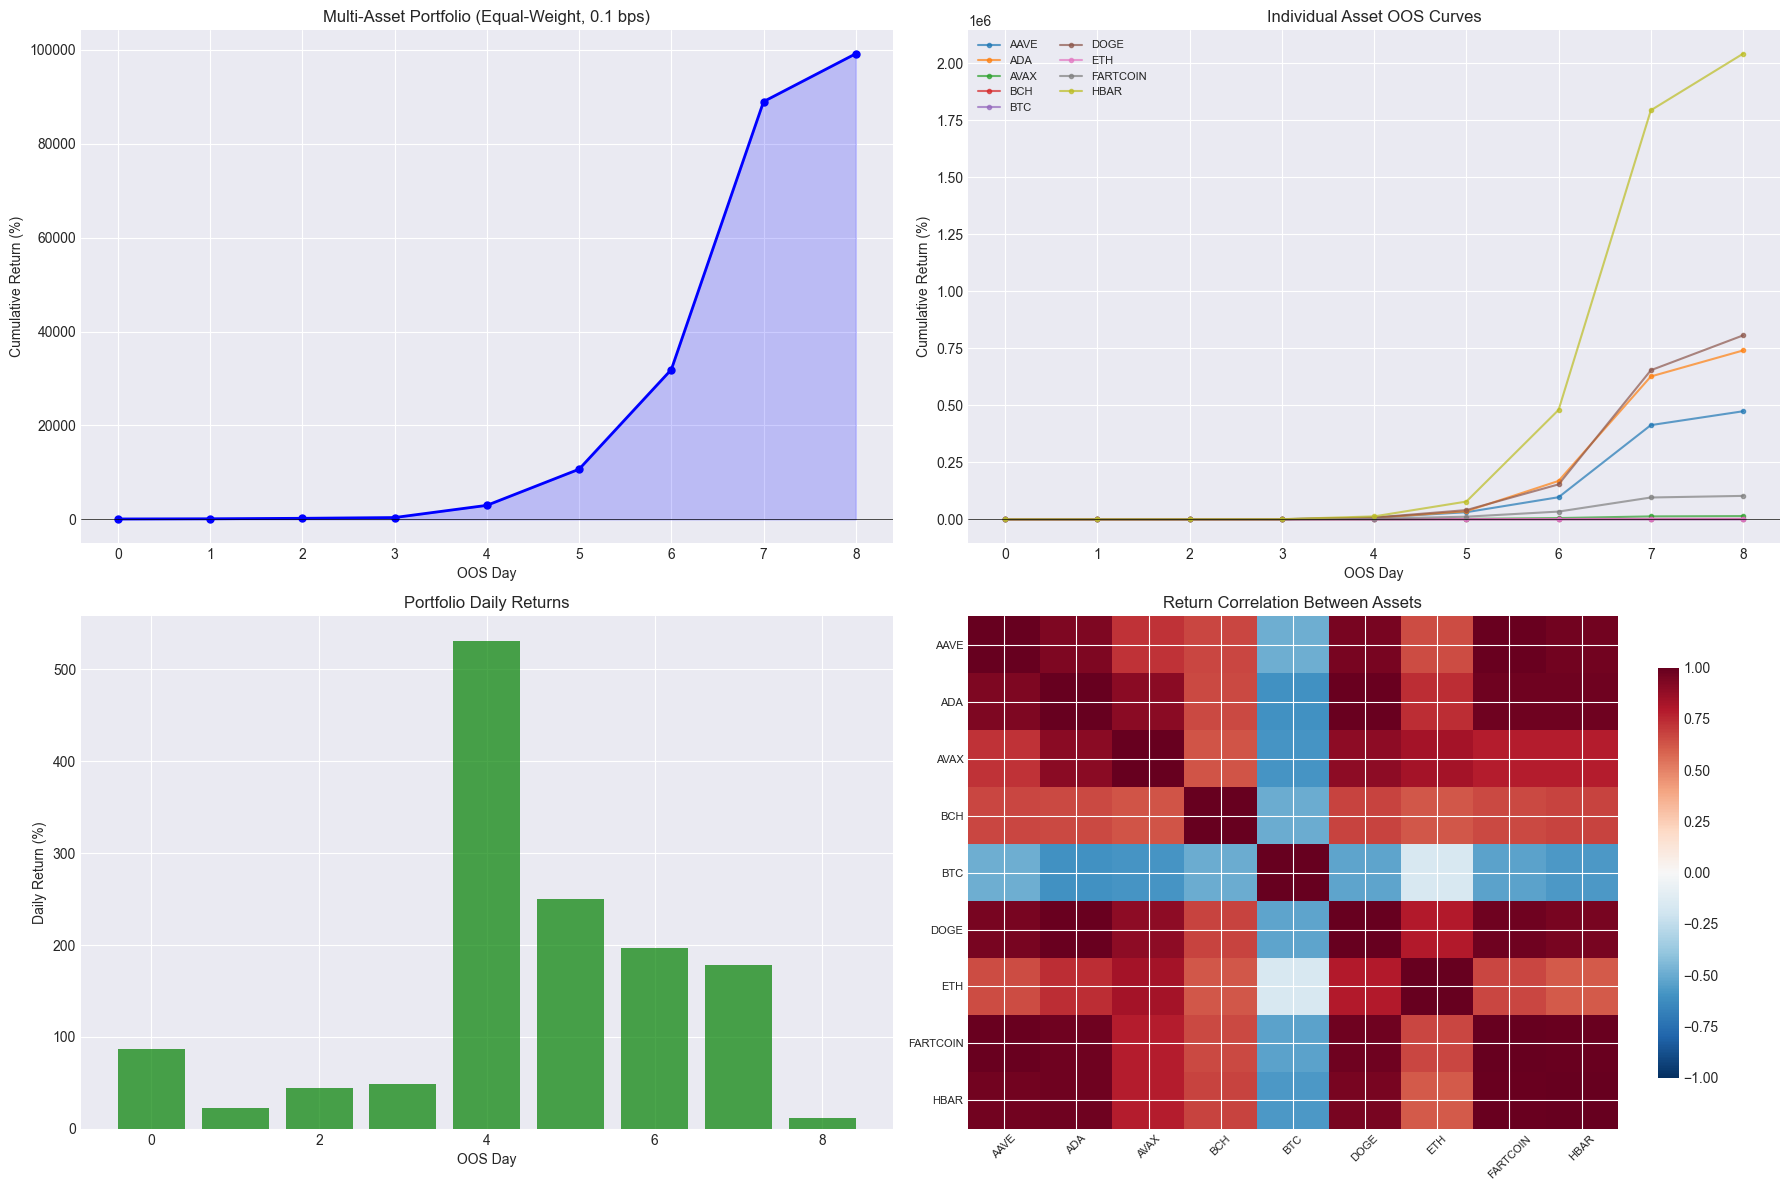

In [14]:
# ═══════════════════════════════════════════════════════════════
# Cell 14: PORTFOLIO VISUALIZATION
# ═══════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Portfolio equity curve
ax = axes[0, 0]
ax.plot(range(len(cum_portfolio)), cum_portfolio, 'b-o', linewidth=2, markersize=5)
ax.fill_between(range(len(cum_portfolio)),
                [min(0, v) for v in cum_portfolio],
                [max(0, v) for v in cum_portfolio],
                alpha=0.2, color='blue')
ax.set_xlabel('OOS Day')
ax.set_ylabel('Cumulative Return (%)')
ax.set_title(f'Multi-Asset Portfolio (Equal-Weight, {FEE_BPS} bps)')
ax.axhline(y=0, color='black', linewidth=0.5)

# 2. Per-asset contribution (stacked daily returns)
ax = axes[0, 1]
for sym in profitable_assets:
    daily_rets = []
    for dt in dates_sorted:
        daily_rets.append(portfolio_daily[dt].get(sym, 0))
    cum = np.cumprod([1 + r/100 for r in daily_rets]) * 100 - 100
    ax.plot(range(len(cum)), cum, marker='o', markersize=3,
            label=sym.replace('-USD',''), alpha=0.7)
ax.set_xlabel('OOS Day')
ax.set_ylabel('Cumulative Return (%)')
ax.set_title('Individual Asset OOS Curves')
ax.legend(fontsize=8, ncol=2)
ax.axhline(y=0, color='black', linewidth=0.5)

# 3. Daily portfolio return histogram
ax = axes[1, 0]
colors = ['green' if r > 0 else 'red' for r in portfolio_returns]
ax.bar(range(len(portfolio_returns)), portfolio_returns, color=colors, alpha=0.7)
ax.set_xlabel('OOS Day')
ax.set_ylabel('Daily Return (%)')
ax.set_title('Portfolio Daily Returns')
ax.axhline(y=0, color='black', linewidth=0.5)

# 4. Correlation between asset daily returns
ax = axes[1, 1]
ret_matrix = pd.DataFrame(portfolio_daily).T
ret_matrix = ret_matrix[profitable_assets].dropna()
if len(ret_matrix) > 2:
    corr = ret_matrix.corr()
    im = ax.imshow(corr.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels([s.replace('-USD','') for s in corr.columns], rotation=45, fontsize=8)
    ax.set_yticks(range(len(corr.columns)))
    ax.set_yticklabels([s.replace('-USD','') for s in corr.columns], fontsize=8)
    ax.set_title('Return Correlation Between Assets')
    plt.colorbar(im, ax=ax, shrink=0.8)
else:
    ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center')

plt.tight_layout()
plt.savefig(str(PROJECT_ROOT / 'research' / 'notebooks' / 'nb04_portfolio.png'), dpi=150)
plt.show()

---
# Part VI: Statistical Validation

Rigorous validation of per-asset and portfolio-level results:
1. Permutation tests (is the signal real?)
2. Bootstrap confidence intervals
3. Multiple comparison correction
4. Fee sensitivity analysis

In [15]:
# ═══════════════════════════════════════════════════════════════
# Cell 15: PERMUTATION TEST (PER ASSET)
# ═══════════════════════════════════════════════════════════════

N_PERMUTATIONS = 1000
rng = np.random.RandomState(42)

permutation_results = {}

for sym in profitable_assets:
    if sym not in ml_results:
        continue
    
    # Observed statistic: total OOS return
    daily_rets = [d['return_pct'] for d in ml_results[sym]['daily']]
    observed = np.mean(daily_rets)
    
    # Permutation: randomly flip signs of daily returns
    perm_stats = []
    for _ in range(N_PERMUTATIONS):
        signs = rng.choice([-1, 1], size=len(daily_rets))
        perm_stat = np.mean(np.array(daily_rets) * signs)
        perm_stats.append(perm_stat)
    
    p_value = np.mean(np.array(perm_stats) >= observed)
    permutation_results[sym] = {
        'observed': observed,
        'p_value': p_value,
        'significant': p_value < 0.05,
    }

print('Permutation Test Results (H0: returns are random):')
print('=' * 60)
for sym, res in sorted(permutation_results.items()):
    sig = 'SIGNIFICANT' if res['significant'] else 'not significant'
    print(f"  {sym:18s}  observed={res['observed']:+.3f}%  p={res['p_value']:.4f}  {sig}")

Permutation Test Results (H0: returns are random):
  AAVE-USD            observed=+233.354%  p=0.0020  SIGNIFICANT
  ADA-USD             observed=+238.692%  p=0.0000  SIGNIFICANT
  AVAX-USD            observed=+85.269%  p=0.0010  SIGNIFICANT
  BCH-USD             observed=+36.414%  p=0.0030  SIGNIFICANT
  BTC-USD             observed=+1.054%  p=0.3830  not significant
  DOGE-USD            observed=+227.935%  p=0.0020  SIGNIFICANT
  ETH-USD             observed=+46.917%  p=0.0020  SIGNIFICANT
  FARTCOIN-USD        observed=+168.036%  p=0.0050  SIGNIFICANT
  HBAR-USD            observed=+331.331%  p=0.0000  SIGNIFICANT


In [16]:
# ═══════════════════════════════════════════════════════════════
# Cell 16: BOOTSTRAP CI + HOLM-BONFERRONI
# ═══════════════════════════════════════════════════════════════

N_BOOTSTRAP = 5000
rng = np.random.RandomState(42)

bootstrap_results = {}

for sym in profitable_assets:
    if sym not in ml_results:
        continue
    
    daily_rets = np.array([d['return_pct'] for d in ml_results[sym]['daily']])
    
    # Bootstrap: resample daily returns with replacement
    boot_means = []
    for _ in range(N_BOOTSTRAP):
        sample = rng.choice(daily_rets, size=len(daily_rets), replace=True)
        boot_means.append(np.mean(sample))
    
    boot_means = np.array(boot_means)
    ci_low, ci_high = np.percentile(boot_means, [2.5, 97.5])
    prob_positive = np.mean(boot_means > 0)
    
    bootstrap_results[sym] = {
        'mean': np.mean(daily_rets),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'prob_positive': prob_positive,
    }

print('Bootstrap Confidence Intervals (5000 resamples):')
print('=' * 70)
for sym, res in sorted(bootstrap_results.items(), key=lambda x: -x[1]['prob_positive']):
    print(f"  {sym:18s}  mean={res['mean']:+.3f}%  "
          f"CI=[{res['ci_low']:+.3f}%, {res['ci_high']:+.3f}%]  "
          f"P(>0)={res['prob_positive']:.1%}")

# Holm-Bonferroni correction
print('\nHolm-Bonferroni Multiple Comparison Correction:')
print('=' * 60)
p_values = sorted(permutation_results.items(), key=lambda x: x[1]['p_value'])
n_tests = len(p_values)
for rank, (sym, res) in enumerate(p_values, 1):
    adjusted_alpha = 0.05 / (n_tests - rank + 1)
    survives = res['p_value'] < adjusted_alpha
    status = 'SURVIVES' if survives else 'REJECTED'
    print(f"  {sym:18s}  p={res['p_value']:.4f}  "
          f"adjusted_alpha={adjusted_alpha:.4f}  {status}")

Bootstrap Confidence Intervals (5000 resamples):
  AAVE-USD            mean=+233.354%  CI=[+85.021%, +446.653%]  P(>0)=100.0%
  ADA-USD             mean=+238.692%  CI=[+101.089%, +408.838%]  P(>0)=100.0%
  AVAX-USD            mean=+85.269%  CI=[+45.375%, +127.960%]  P(>0)=100.0%
  BCH-USD             mean=+36.414%  CI=[+20.940%, +53.478%]  P(>0)=100.0%
  DOGE-USD            mean=+227.935%  CI=[+107.656%, +375.163%]  P(>0)=100.0%
  ETH-USD             mean=+46.917%  CI=[+34.136%, +59.779%]  P(>0)=100.0%
  FARTCOIN-USD        mean=+168.036%  CI=[+58.970%, +318.982%]  P(>0)=100.0%
  HBAR-USD            mean=+331.331%  CI=[+108.255%, +631.143%]  P(>0)=100.0%
  BTC-USD             mean=+1.054%  CI=[-3.142%, +6.607%]  P(>0)=63.2%

Holm-Bonferroni Multiple Comparison Correction:
  ADA-USD             p=0.0000  adjusted_alpha=0.0056  SURVIVES
  HBAR-USD            p=0.0000  adjusted_alpha=0.0063  SURVIVES
  AVAX-USD            p=0.0010  adjusted_alpha=0.0071  SURVIVES
  AAVE-USD            p=0

In [17]:
# ═══════════════════════════════════════════════════════════════
# Cell 17: FEE SENSITIVITY ANALYSIS (ALL ASSETS)
# ═══════════════════════════════════════════════════════════════

FEE_LEVELS = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]

# Re-run backtest at different fee levels for each asset
# Use the ML predictions from Part III, just vary fee
fee_sensitivity = {}  # {symbol: {fee_bps: total_return}}

for sym in profitable_assets:
    if sym not in ml_results:
        continue
    
    loader = DataLoader(str(DATA_ROOT), symbol=sym)
    
    # Get asset-specific features
    asset_feats = asset_top_features.get(sym, [])
    feat_names = [f for f, _ in asset_feats] if len(asset_feats) >= 8 else TOP8_FEATURES
    for f in TOP8_FEATURES:
        if f not in feat_names:
            feat_names.append(f)
    
    # Train model
    train_X_parts, train_y_parts = [], []
    for y, m, d in TRAIN_DATES:
        X, y_t, _ = prepare_day_data(loader, y, m, d, feat_names, HORIZON)
        if X is not None:
            step = max(1, len(X) // 100000)
            train_X_parts.append(X[::step])
            train_y_parts.append(y_t[::step])
        gc.collect()
    
    if not train_X_parts:
        continue
    
    train_X = np.vstack(train_X_parts)
    train_y = np.concatenate(train_y_parts)
    del train_X_parts, train_y_parts; gc.collect()
    
    model = xgb.XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=100,
        tree_method='hist', random_state=42, verbosity=0,
    )
    model.fit(train_X, train_y)
    del train_X, train_y; gc.collect()
    
    fee_sensitivity[sym] = {}
    
    for fee_bps in FEE_LEVELS:
        engine = BacktestEngine(fee_pct=fee_bps/10000)
        daily_rets = []
        
        for y, m, d in TEST_DATES:
            X_test, _, prices_test = prepare_day_data(loader, y, m, d, feat_names, HORIZON)
            if X_test is None or len(X_test) < 1000:
                continue
            
            proba = model.predict_proba(X_test)[:, 1]
            strategy = DirectionStrategy(long_threshold=0.6, short_threshold=0.4, hold_period=HORIZON)
            positions = strategy.generate_positions(prices_test, proba)
            result = engine.run(prices_test, positions)
            daily_rets.append(result.total_return_pct)
            gc.collect()
        
        total = np.prod([1 + r/100 for r in daily_rets]) * 100 - 100 if daily_rets else 0
        fee_sensitivity[sym][fee_bps] = total
    
    del model; gc.collect()
    print(f'{sym}: done')

# Display fee sensitivity table
print('\nFee Sensitivity Analysis (Total OOS Return %)')
print('=' * 80)
fee_df = pd.DataFrame(fee_sensitivity).T
fee_df.columns = [f'{f} bps' for f in FEE_LEVELS]
print(fee_df.to_string(float_format='{:+.1f}'.format))

# Find breakeven fee for each asset
print('\nBreakeven Fee Estimates:')
for sym, fees in fee_sensitivity.items():
    # Interpolate to find breakeven
    sorted_fees = sorted(fees.items())
    breakeven = None
    for i in range(len(sorted_fees) - 1):
        f1, r1 = sorted_fees[i]
        f2, r2 = sorted_fees[i + 1]
        if r1 >= 0 and r2 < 0:
            breakeven = f1 + (f2 - f1) * r1 / (r1 - r2)
            break
    if breakeven:
        print(f'  {sym:18s}  breakeven = {breakeven:.2f} bps')
    elif all(r > 0 for r in fees.values()):
        print(f'  {sym:18s}  profitable at ALL fee levels!')
    else:
        print(f'  {sym:18s}  not profitable')

AAVE-USD: done
ADA-USD: done
AVAX-USD: done
BCH-USD: done
BTC-USD: done
DOGE-USD: done
ETH-USD: done
FARTCOIN-USD: done
HBAR-USD: done

Fee Sensitivity Analysis (Total OOS Return %)
                  0 bps   0.05 bps    0.1 bps   0.15 bps    0.2 bps   0.3 bps   0.5 bps
AAVE-USD      +830587.3  +627368.0  +473863.6  +357912.2  +270327.0 +154195.3  +50128.5
ADA-USD      +1203667.9  +943944.4  +740257.5  +580517.4  +455242.4 +279948.1 +105829.1
AVAX-USD       +16378.0   +15368.8   +14421.5   +13532.1   +12697.2  +11177.7   +8658.4
BCH-USD         +2303.3    +1749.5    +1323.3     +995.4     +743.0    +399.2     +75.1
BTC-USD          +114.0      +51.6       +7.4      -23.9      -46.1     -73.0     -93.2
DOGE-USD     +1563979.4 +1122963.0  +806296.7  +578918.8  +415653.4 +214248.3  +56874.4
ETH-USD         +6927.7    +4431.1    +2821.5    +1783.6    +1114.5    +404.9     -12.8
FARTCOIN-USD  +135286.9  +118003.6  +102926.6   +89774.3   +78300.9  +59561.1  +34448.4
HBAR-USD     +3857548.3 +2

---
# Part VII: Conclusions & Deployment

In [18]:
# ═══════════════════════════════════════════════════════════════
# Cell 18: COMPREHENSIVE CONCLUSIONS
# ═══════════════════════════════════════════════════════════════

print('=' * 70)
print('NOTEBOOK 04: MULTI-ASSET ALPHA EXPANSION — CONCLUSIONS')
print('=' * 70)

print(f'\n1. DATA SCOPE')
print(f'   Symbols: {len(ALL_SYMBOLS)}')
print(f'   Days per symbol: {len(ALL_DATES)}')
print(f'   Train: {len(TRAIN_DATES)} days | Test: {len(TEST_DATES)} days')

print(f'\n2. PER-ASSET ML RESULTS (XGBoost, 0.6/0.4, {HORIZON}-bar hold)')
for _, row in summary_df.iterrows():
    print(f"   {row['Symbol']:18s}  AUC={row['Avg AUC']:.3f}  "
          f"Total={row['Total OOS %']:+.1f}%  "
          f"WR={row['Avg Win Rate']:.1%}  "
          f"Days+={row['Profitable Days']}")

print(f'\n3. PORTFOLIO RESULTS')
print(f'   Assets: {len(profitable_assets)}')
print(f'   Total Return: {portfolio_total:+.1f}%')
print(f'   Daily Win Rate: {profitable_portfolio_days}/{len(dates_sorted)}')
print(f'   Avg Daily Return: {np.mean(portfolio_returns):+.2f}%')

if permutation_results:
    n_sig = sum(1 for r in permutation_results.values() if r['significant'])
    print(f'\n4. STATISTICAL VALIDATION')
    print(f'   Permutation test: {n_sig}/{len(permutation_results)} significant (p<0.05)')
    n_boot_pos = sum(1 for r in bootstrap_results.values() if r['prob_positive'] > 0.95)
    print(f'   Bootstrap P(>0)>95%: {n_boot_pos}/{len(bootstrap_results)} assets')

if fee_sensitivity:
    print(f'\n5. FEE VIABILITY')
    for sym, fees in sorted(fee_sensitivity.items()):
        viable_fees = [f for f, r in fees.items() if r > 0]
        max_fee = max(viable_fees) if viable_fees else 0
        print(f'   {sym:18s}  viable up to {max_fee} bps')

print(f'\n6. NEXT STEPS')
print(f'   - Live paper trading simulation with realistic latency')
print(f'   - Production ML pipeline with daily retraining')
print(f'   - Dynamic asset allocation (weight by AUC/return)')
print(f'   - Collect more data for statistical power')

NOTEBOOK 04: MULTI-ASSET ALPHA EXPANSION — CONCLUSIONS

1. DATA SCOPE
   Symbols: 9
   Days per symbol: 39
   Train: 30 days | Test: 9 days

2. PER-ASSET ML RESULTS (XGBoost, 0.6/0.4, 30-bar hold)
   HBAR-USD            AUC=0.736  Total=+2040818.6%  WR=69.1%  Days+=9/9
   DOGE-USD            AUC=0.762  Total=+806296.7%  WR=72.4%  Days+=9/9
   ADA-USD             AUC=0.779  Total=+740257.5%  WR=65.0%  Days+=9/9
   AAVE-USD            AUC=0.722  Total=+473863.6%  WR=69.6%  Days+=9/9
   FARTCOIN-USD        AUC=0.685  Total=+102926.6%  WR=58.5%  Days+=9/9
   AVAX-USD            AUC=0.827  Total=+14421.5%  WR=61.2%  Days+=9/9
   ETH-USD             AUC=0.616  Total=+2821.5%  WR=53.7%  Days+=9/9
   BCH-USD             AUC=0.622  Total=+1323.3%  WR=57.6%  Days+=9/9
   BTC-USD             AUC=0.576  Total=+7.4%  WR=47.1%  Days+=5/9

3. PORTFOLIO RESULTS
   Assets: 9
   Total Return: +99200.9%
   Daily Win Rate: 9/9
   Avg Daily Return: +152.11%

4. STATISTICAL VALIDATION
   Permutation test: 8

In [19]:
# ═══════════════════════════════════════════════════════════════
# Cell 19: EXPORT DEPLOYMENT BUNDLE
# ═══════════════════════════════════════════════════════════════

deploy_dir = PROJECT_ROOT / 'research' / 'deployments' / 'alpha_v3_multi_asset'
deploy_dir.mkdir(parents=True, exist_ok=True)

# 1. Config
config = {
    'notebook': '04_multi_asset_alpha_expansion',
    'strategy': 'XGBoost Direction Classifier',
    'thresholds': {'long': 0.6, 'short': 0.4},
    'horizon': HORIZON,
    'fee_bps': FEE_BPS,
    'train_days': len(TRAIN_DATES),
    'test_days': len(TEST_DATES),
    'symbols': ALL_SYMBOLS,
    'profitable_assets': profitable_assets,
    'features': {
        'universal_top8': TOP8_FEATURES,
        'full_set_size': len(FEATURE_COLS),
    },
}
(deploy_dir / 'config.json').write_text(json.dumps(config, indent=2))

# 2. ML results
summary_df.to_csv(deploy_dir / 'ml_results_by_asset.csv', index=False)

# 3. Feature importance
fi_sorted.to_csv(deploy_dir / 'feature_importance_by_asset.csv')

# 4. Portfolio daily results
pd.DataFrame(portfolio_detail).to_csv(deploy_dir / 'portfolio_daily.csv', index=False)

# 5. Fee sensitivity
if fee_sensitivity:
    fee_df.to_csv(deploy_dir / 'fee_sensitivity.csv')

# 6. Correlation matrix
corr_matrix.to_csv(deploy_dir / 'signal_correlations_by_asset.csv')

# 7. Per-asset features
asset_feat_export = {sym: [{'feature': f, 'corr': c} for f, c in tops]
                     for sym, tops in asset_top_features.items()}
(deploy_dir / 'per_asset_features.json').write_text(
    json.dumps(asset_feat_export, indent=2)
)

print(f'Deployment bundle saved to: {deploy_dir}')
for f in sorted(deploy_dir.iterdir()):
    print(f'  {f.name} ({f.stat().st_size/1024:.1f} KB)')

Deployment bundle saved to: c:\Users\longp\daedalus\research\deployments\alpha_v3_multi_asset
  config.json (0.8 KB)
  feature_importance_by_asset.csv (3.6 KB)
  fee_sensitivity.csv (1.3 KB)
  ml_results_by_asset.csv (1.1 KB)
  per_asset_features.json (9.3 KB)
  portfolio_daily.csv (0.8 KB)
  signal_correlations_by_asset.csv (16.6 KB)
